Loading the Data

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- File Paths ---
INPUT_FILE = "../data/interim/pakistan_district_climate_history.csv"
OUTPUT_DIR_INTERMEDIATE = "../data/interim/"

# Load Dataset
print(f"📂 Loading {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)
df['time'] = pd.to_datetime(df['time'])

# Initial Clean Check
print(f"Original Rows: {len(df):,}")
print(f"Original Columns: {list(df.columns)}")

📂 Loading ../data/interim/pakistan_district_climate_history.csv...
Original Rows: 5,961,600
Original Columns: ['time', 'temp_2m', 'dew_point', 'tp', 'wind_u', 'wind_v', 'solar_rad', 'number', 'expver', 'district_name']


Structural Cleanup: Dropping ghost columns and Standardizing Time

In [4]:

print("Dropping Ghost Columns (expver, number) ---")
cols_to_drop = ['expver', 'number']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

print("Handling Duplicate Rows ")
# This handles the ERA5 expver duplicates that might have existed
df = df.groupby(['time', 'district_name'], as_index=False).first()
print(f"Rows after deduplication: {len(df):,}")

print("Standardizing Time Column")
# Renames valid_time to time, which is common in newer ERA5 API downloads
if 'valid_time' in df.columns:
    df = df.rename(columns={'valid_time': 'time'})
    print("Renamed 'valid_time' to 'time'.")
else:
    print("Time column already named 'time'.")
    
display(df.head())

Dropping Ghost Columns (expver, number) ---
Handling Duplicate Rows 
Rows after deduplication: 5,961,600
Standardizing Time Column
Time column already named 'time'.


,time,district_name,temp_2m,dew_point,tp,wind_u,wind_v,solar_rad
0,2015-04-01,Abbottabad,282.30640,279.75980,1.330937e-02,-1.608655,-0.909447,13252956.0
1,2015-04-01,Adam Khel,286.43408,285.84006,2.228624e-02,0.222826,-0.999734,10255635.0
2,2015-04-01,Attok,288.20413,287.50647,1.634783e-02,-0.307827,-1.264785,13133206.0
3,2015-04-01,Awaran,292.37988,288.89010,1.476699e-06,1.284068,0.975949,25950052.0
4,2015-04-01,Badin,294.38907,293.39390,8.523459e-07,2.797036,1.455528,25496864.0


Kelvin to Celcius Temerature

In [5]:
KELVIN_TO_CELSIUS = 273.15

print(f"Converting Temp and Dew Point from Kelvin to Celsius (subtracting {KELVIN_TO_CELSIUS}).")

# Convert to Celsius
df['temp_c'] = df['temp_2m'] - KELVIN_TO_CELSIUS
df['dew_point_c'] = df['dew_point'] - KELVIN_TO_CELSIUS

Converting Temp and Dew Point from Kelvin to Celsius (subtracting 273.15).


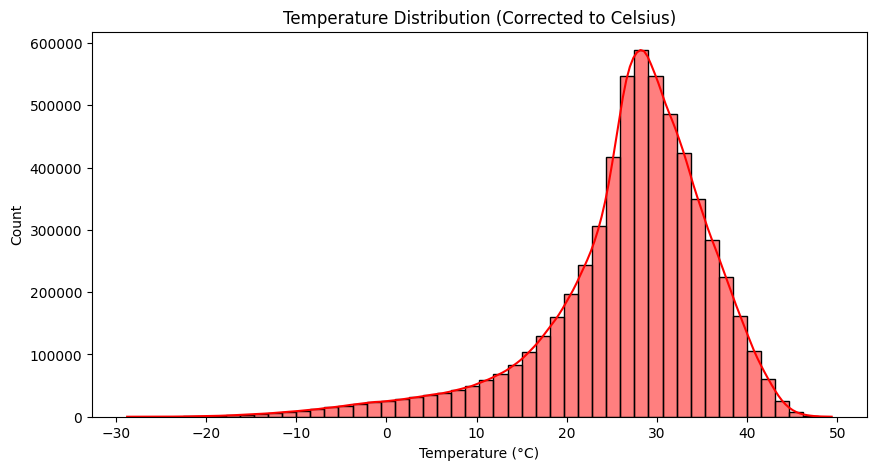

,temp_2m,temp_c,dew_point_c
0,282.30640,9.15640,6.60980
1,286.43408,13.28408,12.69006
2,288.20413,15.05413,14.35647
3,292.37988,19.22988,15.74010
4,294.38907,21.23907,20.24390


In [6]:
plt.figure(figsize=(10, 5))
sns.histplot(df['temp_c'], bins=50, kde=True, color="red")
plt.title("Temperature Distribution (Corrected to Celsius)")
plt.xlabel("Temperature (°C)")
plt.show()

display(df[['temp_2m', 'temp_c', 'dew_point_c']].head())

Physics Cleanup: Solar Radiation De-Accumulation

In [7]:
SECONDS_PER_HOUR = 3600

print("Calculating instantaneous Solar Radiation...")
df = df.sort_values(['district_name', 'time']).reset_index(drop=True)

# 1. Calculate the difference between the current hour and the previous hour (grouped by district)
# This is (Cumulative_t) - (Cumulative_t-1) = (Instantaneous_t)
df['solar_hourly_joules'] = df.groupby('district_name')['solar_rad'].diff()

# 2. Handle the "Reset" at midnight (where diff is large negative)
# We assume negative values or NaN (first hour) means 0 or the reset point.
df['solar_hourly_joules'] = df['solar_hourly_joules'].clip(lower=0)
df['solar_hourly_joules'] = df['solar_hourly_joules'].fillna(0) # Fill the NaN from .diff()

# 3. Convert Joules (Energy) to Watts (Power)
df['solar_w_m2'] = df['solar_hourly_joules'] / SECONDS_PER_HOUR

# 4. Cap extreme outliers (Artifacts/Noise)
# Max solar constant is ~1361 W/m2. Cap high noise.
df.loc[df['solar_w_m2'] > 1200, 'solar_w_m2'] = 1200

print(f"Mean Solar Power: {df['solar_w_m2'].mean():.2f} W/m²")

Calculating instantaneous Solar Radiation...
Mean Solar Power: 266.69 W/m²


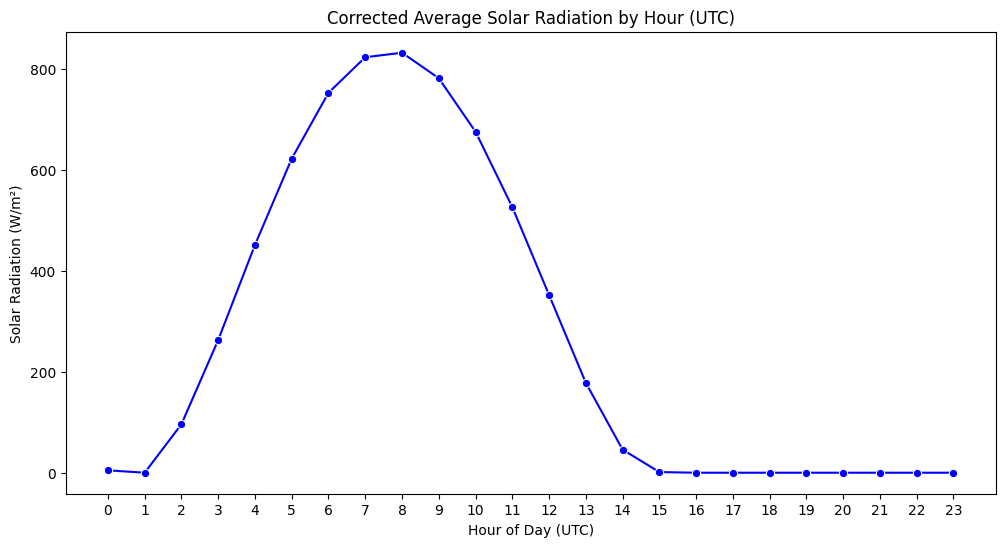

In [8]:
df['hour'] = df['time'].dt.hour
hourly_solar_fixed = df.groupby('hour')['solar_w_m2'].mean()

plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_solar_fixed.index, y=hourly_solar_fixed.values, marker="o", color="blue")
plt.title("Corrected Average Solar Radiation by Hour (UTC)")
plt.xlabel("Hour of Day (UTC)")
plt.ylabel("Solar Radiation (W/m²)")
plt.xticks(range(0, 24))
plt.show()

In [9]:
# Drop the raw solar columns
df = df.drop(columns=['solar_rad', 'solar_hourly_joules'])

District Names Standardization:

In [10]:
name_corrections = {
    # Fix Typos/Alternate Spellings
    "Jakobabad": "Jacobabad",
    "Attok": "Attock",
    "Mirphurkhas": "Mirpur Khas",
    "Dera Ghazi Kha": "Dera Ghazi Khan",
    "Tando M. Khan": "Tando Muhammad Khan",
    "M. B. Din": "Mandi Bahauddin",
    
    # Merge Split Districts (GADM artifacts)
    "Gujranwala 1": "Gujranwala",
    "Gujranwala 2": "Gujranwala",
    "Narowal 1": "Narowal",
    "Narowal 2": "Narowal",
    "Okara 1": "Okara",
    
    # Standardize Tribal/Special Areas
    "Malakand P.A.": "Malakand",
    "N. Waziristan": "North Waziristan",
    "S. Waziristan": "South Waziristan",
    "Adam Khel": "Kohat", 
    "Bhitani": "Lakki Marwat", 
    "Largha Shirani": "Sherani"
}

print(" Applying District Name Standardization...")
df['district_name'] = df['district_name'].replace(name_corrections)

# Re-aggregate due to merged districts (e.g., Gujranwala 1 & 2 are now just Gujranwala)
# This takes the mean of the two merged regions for that hour
df = df.groupby(['time', 'district_name'], as_index=False).mean()



 Applying District Name Standardization...


In [11]:
# Drop Noise Regions (Disputed/Irrelevant slivers)
drop_list = [
    "Disputed Area 1", 
    "Kargil", 
    "Ladakh (Leh)", 
    "Kupwara (Gilgit Wazarat)"
]
df = df[~df['district_name'].isin(drop_list)]

print(f"Final Unique Districts: {df['district_name'].nunique()}")
display(df[['district_name']].value_counts().head(5))

Final Unique Districts: 130


district_name
Abbottabad       43200
Attock           43200
Awaran           43200
Badin            43200
Bagh             43200
Name: count, dtype: int64

In [12]:
for d in df['district_name'].unique():
    print (d)

Abbottabad
Attock
Awaran
Badin
Bagh
Bahawalnagar
Bahawalpur
Bajaur
Bannu
Barkhan
Battagram
Bhakkar
Bhimber
Bhittani
Bolan
Buner
Chagai
Chakwal
Charsadda
Chilas
Chitral
Dadu
Dera Bugti
Dera Ghazi Khan
Dera Ismail Khan
Dir
Faisalabad
Ghotki
Gilgit
Gilgit (Tribal Territory)
Gujarat
Gujranwala
Gujrat
Gwadar
Hafizabad
Hangu
Haripur
Hyderabad
Islamabad
Jacobabad
Jafarabad
Jamshoro
Jhal Magsi
Jhang
Jhelum
Kalat
Karachi East
Karachi west
Karak
Kashmore
Kasur
Kech
Khairpur
Khanewal
Kharan
Kholu
Khushab
Khuzdar
Khyber
Kohat
Kohistan
Kotli
Kurram
Lahore
Lakki Marwat
Larkana
Lasbela
Layyah
Lodhran
Loralai
Malakand
Malir
Mansehra
Mardan
Mastung
Matiari
Mianwali
Mirpur
Mirpur Khas
Mithi
Mohmand
Multan
Musakhel
Muzaffarabad
Muzaffargarh
Nankana Sahib
Narowal
Nasirabad
Naushahro Firoz
Nawab Shah
Neelum
North Waziristan
Nowshera
Okara
Orakzai
Pakpattan
Panjgur
Peshawar
Pishin
Poonch
Qilla Abdullah
Qilla Saifullah
Quetta
Rahimyar Khan
Rajan Pur
Rann of Kutch
Rawalpindi
Sahiwal
Sanghar
Sargodha
Shangla
S

Saving to Interim Folder

In [13]:
# --- Final Save ---
OUTPUT_FILE = os.path.join(OUTPUT_DIR_INTERMEDIATE, "clean_district_climate_history.csv")

# Drop the final remaining raw ERA5 column
df = df.drop(columns=['tp'], errors='ignore')

print(f"Saving final cleaned dataset ({len(df):,} rows) to {OUTPUT_FILE}")
df.to_csv(OUTPUT_FILE, index=False)
print(" Preprocessing (Notebook 02) Complete!")

Saving final cleaned dataset (5,616,000 rows) to ../data/interim/clean_district_climate_history.csv
 Preprocessing (Notebook 02) Complete!
